In [1]:
import mdtraj as md
import numpy as np
from pymol import cmd
from pymol import stored
import matplotlib.pyplot as plt
import itertools
import warnings
import multiprocessing
from tqdm import tqdm
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import glob

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [3]:
def save_pocket(pdb, sdf, name):
    cmd.reinitialize()
    cmd.load(pdb)
    cmd.load(sdf, "LIG")
    cmd.select("POCK","br. LIG around 4")
    stored.idx = 0
    cmd.iterate("POCK and n. CA", expression="stored.idx+=1")
    cmd.save(name, "POCK")
    return stored.idx

In [4]:
# dict_aa = {'CYS': 0, 'ASP': 1, 'SER': 2, 'GLN': 3, 'LYS': 4,
#      'ILE': 5, 'PRO': 6, 'THR': 7, 'PHE': 8, 'ASN': 9, 
#      'GLY': 10, 'HIS': 11, 'LEU': 12, 'ARG': 13, 'TRP': 14, 
#      'ALA': 15, 'VAL':16, 'GLU': 17, 'TYR': 18, 'MET': 19}

# dict_element = {"H": 20, "I":21,
#        "N": 22,
#        "P":23,
#        "C": 24,
#        "O":25,
#        "F": 26,
#        "S": 27,
#        "Li": 28,
#        "Cl": 29,
#        "Br": 30}

aa_hscale = {
"ALA":  0.620,
"ARG": -2.530,
"ASN": -0.780,
"ASP": -0.900,
"CYS":  0.290,
"GLN": -0.850,
"GLU": -0.740,
"GLY":  0.480,
"HIS": -0.400,
"ILE":  1.380,
"LEU":  1.060,
"LYS": -1.500,
"MET":  0.640,
"PHE":  1.190,
"PRO":  0.120,
"SER": -0.180,
"THR": -0.050,
"TRP":  0.810,
"TYR":  0.260,
"VAL":  1.080}

element_charge = {"H": +1, "I":-1,
           "N": -3,
           "P":-3,
           "C": +4,
           "O":-2,
           "F": -1,
           "S": -2,
           "Li": +1,
           "Cl": -1,
           "Br": -1}

In [11]:
'4'.isdigit()

True

In [181]:
# convert files into list of strings
# for the protein pdb and ligand sdf 
# (states are separated by $$$$)
def stringify(sdf, pdb, num_states):
    sdf_split = []
    with open(sdf,'r') as f:
        for key,group in itertools.groupby(f,lambda line: line.startswith('$$$$')):
          if not key:
            sdf_split.append("".join(list(group)))
          if len(sdf_split) == num_states:
            break
    
#     with open(sdf,'r') as f:
#         lines = f.readlines()
#     lines = "".join(lines)
#     test_split=lines.split("$$$$")
    
#     correct=True
#     for i,j in zip(test_split,sdf_split):
#         correct = correct and i == j
#         if i != j :
#             print(i)
#             print(j)
#             return
#     print(correct)
#     return
        
    #sdf_split = sdf_split[-num_states:]
    with open(pdb,'r') as f:
        pdb_string = f.readlines()       
    return sdf_split, "".join(pdb_string)

def find_end(lines):
    filtered_lines=[]
    for l in lines:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        vals1 = (split[0])
        
        # stop when we get to the integers in the sdf
        if vals1.isdigit():
            return filtered_lines
        filtered_lines.append(l)
            
def create_pdb(sdf, pdb_string,i):
    lines = sdf.split('\n')
    #num_lines = (int)(lines[3].split(' ')[1])
    
    #lig = lines[4:4+num_lines-1]
    lig = find_end(lines[4:])
    lig = list(filter(lambda x: 'H' not in x, lig))
    lig_pdb = list(map(create_line, lig, np.arange(1,len(lig)+1)))
    f =  open("tmp{0}.pdb".format(i), 'w+')
    f.write("\n".join(lig_pdb))
    f.write("\n")
    f.write(pdb_string)
    f.close()

# Create one line in the new pdb file for one state
# and the protein
# Use the standardized pdb regex to create the correct string
def create_line(line,i):
    split = line.split(' ')
    split = list(filter(lambda x: x != '', split))
    vals1 = (float)(split[0])
    vals2 = (float)(split[1])
    vals3= (float)(split[2]) 
    atom = split[3]

    # workaround to get the atoms in the ligand to be residues in mdtraj reader
    if i >=10 :
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"U"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    else:
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"UN"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    return new_string

# Create the data for ML model

# First array is contact matrix
# - ----------------| ligand atoms | protein residues
# - ligand atoms    |              | 
# ------------------|--------------|-----------------
# - protein residues|              |
#
# Second array is a mask for which cells correspond to ligand x ligand (-1), 
# protein x protein (1) and ligand x protein (0)
#
# Arrays are interpolated to 80x80
def maker_w_strings(data):
    i,sdf_state, num_residues, pdb = data
    tmp_file = str(id(multiprocessing.current_process()))
    create_pdb(sdf_state,pdb,tmp_file) # create the pdb for one states
    
    # Load the file into mdtraj
    t = md.load("tmp{0}.pdb".format(tmp_file))
    pl = len(list(t.topology.residues))
    resi = np.arange(pl)
    pairs = list(itertools.product(resi, resi))
    
    # compute constacts
    matrix, l = md.compute_contacts(t, contacts=pairs, scheme="closest-heavy")
    matrix = np.array(matrix).reshape((pl,pl))
    
    aa_matrix_h = np.zeros((pl, pl))
    aa_matrix_v = np.zeros((pl, pl))
    resi_list = list(t.topology.residues)
    atom_list = list(t.topology.atoms)

    for p in range(pl):
        r = resi_list[p]
        if not str(r).startswith('U'):
            aa_matrix_v[:,p]=aa_hscale[r.name]
            aa_matrix_h[p]=aa_hscale[r.name]
        else:
            a = atom_list[p]
            aa_matrix_v[:,p] =element_charge[a.name]
            aa_matrix_h[p]=element_charge[a.name]
            
    ### generate protein-ligand mask
    mask = np.zeros((pl,pl))
    for i in range(pl-num_residues):
        for j in range(pl-num_residues):
            # ligand
            mask[i,j] = -1
            
    for i in range(pl - num_residues,pl):
        for j in range( pl - num_residues,pl):
            # protein
            mask[i,j] = 1
            
    p_img = cv2.resize(matrix, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    m_img = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    v_img = cv2.resize(aa_matrix_v, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    h_img = cv2.resize(aa_matrix_h, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)

    p_contact_matrix = np.concatenate([p_img, m_img, v_img, h_img], axis=-1)
    os.remove("tmp{0}.pdb".format(tmp_file))
    return p_contact_matrix
    

In [182]:
maps=[]
num_residues = save_pocket("april27/ADRP/ADRP_6W02_A_1_H.pdb", "april27/ADRP/adrp_adpr_A_cat_sorted_top100.sdf", "april27/ADRP/adrp_gen_pock.pdb")
print("done creating pocket")
s, pdb_string = stringify("april27/ADRP/adrp_adpr_A_cat_sorted.sdf", "april27/ADRP/adrp_gen_pock.pdb", 10000)
pdb_string = [pdb_string for x in range(len(s))]

with multiprocessing.Pool(32) as p:
    num_states = len(s)
    data = list(zip(range(num_states), s, num_residues*np.ones(num_states,dtype=int), pdb_string))
    itern = p.imap(maker_w_strings, data)
    for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
        maps.append(p_contact_matrix)


done creating pocket


100%|██████████| 10000/10000 [00:52<00:00, 191.08it/s]


In [183]:
images_100k = np.stack(maps,axis=0)
print(images_100k.shape)

(10000, 64, 64, 4)


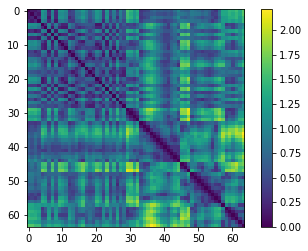

In [184]:
plt.imshow(maps[0][:,:,0])
plt.colorbar()

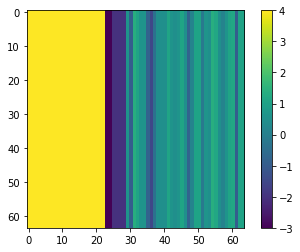

In [27]:
plt.imshow(maps[10][:,:,2])
plt.colorbar()

In [185]:
df = pd.read_csv("april27/ADRP/adrp_adpr_A_cat_sorted.csv")
print(df.iloc[0])

SMILES        Cc1c([nH]c2c1c(ncn2)NC(=O)[C@@H](C)SCc3[nH]c(=...
TITLE                                             SIM-32751-E15
receptor                                          Not Available
Chemgauss4                                             -13.8507
Name: 0, dtype: object


In [193]:
data_images =[]
data_scores = []
data_images_bottom =[]
data_scores_bottom = []
files_m = glob.glob('./**/*high.matrices.npy', recursive=True)
files_s = glob.glob('./**/*.scores', recursive=True)
for m,s in zip(files_m, files_s):
    print(m,s)
#     if "bottom" not in m:
    data_images.append(np.load(m)[0:5000])
    data_scores.append(pd.read_csv(s).iloc[0:5000])
#     else:
#     data_images_bottom.append(np.load(m)[-5000:])
#     data_scores_bottom.append(pd.read_csv(s).iloc[-5000:])
    

./april27/PLPro/2/plpro_2.high.matrices.npy ./april27/PLPro/2/plpro_2.scores
./april27/PLPro/1/plpro_1.high.matrices.npy ./april27/PLPro/1/plpro_1.scores
./april27/NSP15_6w01/2/NSP15_2_6w01.high.matrices.npy ./april27/NSP15_6w01/2/NSP15_2_6w01.scores
./april27/NSP15_6w01/1/NSP15_1_6w01.high.matrices.npy ./april27/NSP15_6w01/1/NSP15_1_6w01.scores
./april27/NSP15_6vww/1/NSP15_1_6vww.high.matrices.npy ./april27/NSP15_6vww/1/NSP15_1_6vww.scores
./april27/NSP15_6vww/2/NSP15_2_6vww.high.matrices.npy ./april27/NSP15_6vww/2/NSP15_2_6vww.scores
./april27/3CLPro/1/3CLPro_1.high.matrices.npy ./april27/3CLPro/1/3CLPro_1.scores
./april27/3CLPro/2/3CLPro_2.high.matrices.npy ./april27/3CLPro/2/3CLPro_2.scores
./april27/3CLPro/3/3CLPro_3.high.matrices.npy ./april27/3CLPro/3/3CLPro_3.scores
./april27/ADRP/ADRP_6W02_A_1_H.high.matrices.npy ./april27/ADRP/ADRP_6W02_A_1_H.scores
./april27/DNMT3A/DNMT3A_chainA.high.matrices.npy ./april27/DNMT3A/DNMT3A_chainA.scores
./april27/NSUN2/NSUN2_model.high.matrices

In [209]:
X = np.vstack(data_images)
y = pd.concat(data_scores)
# X = np.stack(maps,axis=0)
print(X.shape)
print(y.head)

(60000, 64, 64, 4)
<bound method NDFrame.head of       Unnamed: 0                                             SMILES  \
0              0       c1cc(cc(c1)NC(=O)NCc2ccncc2)NC(=O)c3ccc[nH]3   
1              1            c1ccc2c(c1)c3c4c(c5cnccc5c3[nH]2)CNC4=O   
2              2  Cc1c(cc(c2c1oc(c(c2=O)[O-])c3[nH]c(c[nH+]3)Cl)...   
3              3  Cc1c(cc(c2c1oc(c(c2=O)[O-])c3[nH]c(c[nH+]3)OC)...   
4              4  C[C@H]1[C@@H]2[C@H]3[C@H]4[C@@H]([C@@H]([C@@H]...   
...          ...                                                ...   
4995        4995  c1ccc(cc1)c2c[nH+]c([nH]2)CNC(=O)c3cc4cc(sc4[n...   
4996        4996   C[C@@H](C(=O)N1CCC1)Sc2nc([nH]n2)c3ccc4c(c3)CCC4   
4997        4997              c1ccc(c(c1)c2cc(n[nH]2)C(=O)NCCOCCO)O   
4998        4998      C[C@@H](c1cccs1)NC(=O)c2cc([nH]n2)c3ccc(cc3)F   
4999        4999      C[C@@H](c1cccs1)NC(=O)c2cc([nH]n2)c3ccc(cc3)F   

               TITLE                   receptor  Chemgauss4  
0         T2K-520944    april27/PLPr

In [212]:
print(y['Chemgauss4'])

0      -13.482728
1      -13.324015
2      -13.313546
3      -13.262964
4      -13.218845
          ...    
4995   -10.162597
4996   -10.162563
4997   -10.162533
4998   -10.162489
4999   -10.162489
Name: Chemgauss4, Length: 60000, dtype: float64


In [218]:
scaler = MinMaxScaler()
dock_score= np.clip(-100, 0, y['Chemgauss4']).to_numpy()
dock_score = np.abs(dock_score)
dock_score = scaler.fit_transform(dock_score.reshape(-1,1))
y['Chemgauss4'] = dock_score

In [219]:
print(X.shape, dock_score.shape)

(60000, 64, 64, 4) (60000, 1)


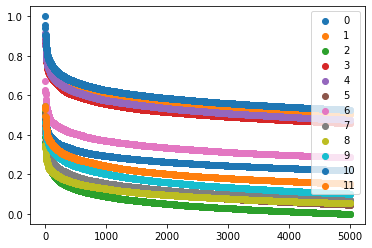

In [220]:
for i in range(12):
    plt.scatter(np.arange(5000), dock_score[5000*i:5000*(i+1)], label=i)
plt.legend()    

(60000, 64, 64, 2)
(60000, 64, 64, 2)


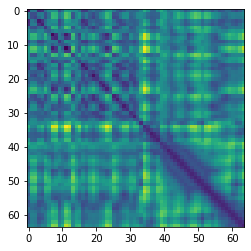

In [221]:
X_2d = X[:,:,:,0:2]
print(X_2d.shape)
plt.imshow(X_2d[0][:,:,0])

X_2d_bottom = X_bottom[:,:,:,0:2]
print(X_2d_bottom.shape)

In [222]:
# X_train, X_test, y_train, y_test = train_test_split(X_set,y_set, test_size=0.25,
#                                                      shuffle=True)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_2d, y, test_size=0.25,
                                                     shuffle=True)

In [237]:
dock_score_train=y_train_top["Chemgauss4"].to_numpy()
dock_score_test = y_test_top["Chemgauss4"].to_numpy()

In [129]:
# X_train_3d = np.array([ np.concatenate((X_train_top[i],np.expand_dims(X_train_top[i][:,:,0], axis=-1)), axis=-1) for i in range(X_train_top.shape[0])])
# print(X_train_3d.shape)
# X_test_3d = np.array([ np.concatenate((X_test_top[i],np.expand_dims(X_test_top[i][:,:,0], axis=-1)), axis=-1) for i in range(X_test_top.shape[0])])
# print(X_test_3d.shape)

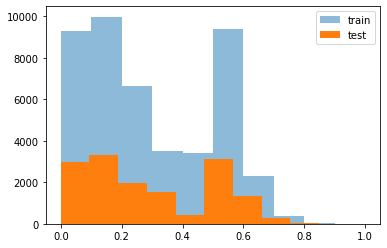

In [236]:
plt.hist(dock_score_train, alpha=0.5, label='train')
plt.hist(dock_score_test,alpha=1, label='test')
#plt.hist(scores,alpha=0.25, label='100k scores')
plt.legend()

In [224]:
def adapt_learning_rate(epoch):
    return 1e-3 * epoch
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [225]:
def r2_keras(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [226]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# # applying transformation to image
# train_gen = ImageDataGenerator(rotation_range=180)
# test_gen = ImageDataGenerator()
# training_set= train_gen.flow(X_train_3d, y_train_top, batch_size=64)
# test_set= train_gen.flow(X_test_3d, y_test_top, batch_size=64)

In [244]:
dr = 0.1
model = Sequential()
model.add(Conv2D(8, kernel_size=(6, 6),
                 activation='relu',
                 input_shape=(64,64,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(dr))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(lr=5e-6),
              metrics=['mean_squared_error', r2_keras])
print(model.summary())
history = model.fit(X_train_top, y_train_top['Chemgauss4'],
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(X_test_top, y_test_top['Chemgauss4']))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 59, 59, 8)         584       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 57, 57, 32)        2336      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 55, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 27, 27, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 23328)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)               

Epoch 31/50
45000/45000 [==============================] - 6s 131us/sample - loss: 0.0038 - mean_squared_error: 0.0038 - r2_keras: 0.9057 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_r2_keras: 0.9253
Epoch 32/50
45000/45000 [==============================] - 6s 136us/sample - loss: 0.0037 - mean_squared_error: 0.0037 - r2_keras: 0.9073 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_r2_keras: 0.9246
Epoch 33/50
45000/45000 [==============================] - 6s 132us/sample - loss: 0.0037 - mean_squared_error: 0.0037 - r2_keras: 0.9066 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_r2_keras: 0.9172
Epoch 34/50
45000/45000 [==============================] - 6s 123us/sample - loss: 0.0036 - mean_squared_error: 0.0036 - r2_keras: 0.9087 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_r2_keras: 0.9234
Epoch 35/50
45000/45000 [==============================] - 6s 134us/sample - loss: 0.0037 - mean_squared_error: 0.0037 - r2_keras: 0.9080 - val_loss

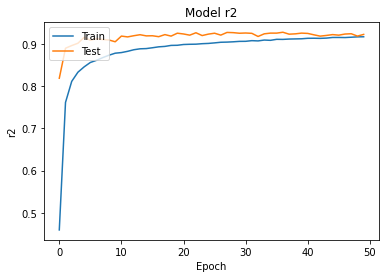

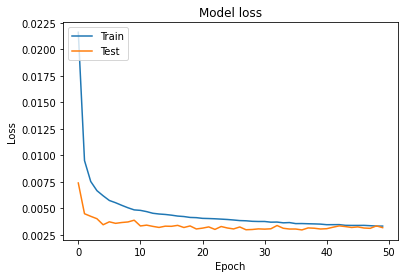

In [245]:
# Plot training & validation loss values
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('Model r2')
plt.ylabel('r2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [246]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test_top)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(dock_score_test.reshape(-1,1))
y_train_inv = scaler.inverse_transform(dock_score_train.reshape(-1,1))

#print(r2_score(y_test_top, y_pred))
print(r2_score(y_test_inv, y_pred_inv))

0.9229512769683382


In [247]:
print(np.argmax(y_pred_inv))
print(np.max(y_pred_inv))

print(np.argmax(y_test_inv))
print(np.max(y_test_inv))

6960
15.131067
8757
17.595382999999995


In [250]:
y_test_top.iloc[np.argmax(y_pred_inv)]

Unnamed: 0                                                 1979
SMILES        c1cc(c(cc1C(=O)[O-])[C@H]2c3cc(ccc3CC4([NH2+]2...
TITLE                                                T2K-353497
receptor                           april27/DNMT3A/DNMT3A_chainA
Chemgauss4                                             0.586223
Name: 1979, dtype: object

In [242]:
y_test_top.iloc[np.argmax(y_pred_inv)]["SMILES"]

'c1cc2c(cc1Cl)[C@@H]([NH2+]C3(C2)CCN(CC3)c4c5cc[nH]c5ncn4)c6ccc(cc6O)Cl'

In [249]:
y_test_top.iloc[np.argmax(y_test_inv)]["SMILES"]

'c1cc2c(cc[nH]2)c(c1)NC(=O)c3c[nH]nc3c4ccc(cc4)F'

In [243]:
y_test_top.iloc[np.argmax(y_test_inv)]["SMILES"]

'c1cc2c(cc[nH]2)c(c1)NC(=O)c3c[nH]nc3c4ccc(cc4)F'

In [171]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print(pearsonr(y_test_inv.flatten(),y_pred_inv.flatten()))
print(spearmanr(y_test_inv.flatten(),y_pred_inv.flatten()))
# print(pearsonr(y_test_top.flatten(),y_pred.flatten()))
# print(spearmanr(y_test_top.flatten(),y_pred.flatten()))

(0.9651940131236157, 0.0)
SpearmanrResult(correlation=0.938452273573127, pvalue=0.0)


In [172]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(y_test_top, y_pred))
print(mean_squared_error(y_test_inv, y_pred_inv))

0.0028665663716548506
0.0028665663716548506


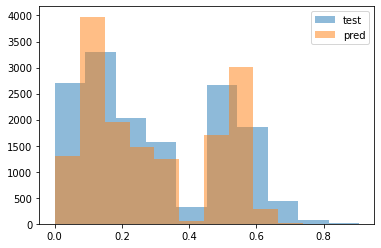

In [173]:
# plt.hist(y_test_top, alpha=0.5, label="test")
# plt.hist(y_pred, alpha=0.5, label="pred")
# plt.show()
plt.hist(y_test_inv, alpha=0.5, label="test")
#plt.show()
plt.hist(y_pred_inv,alpha=0.5, label="pred")
plt.legend()
plt.show()

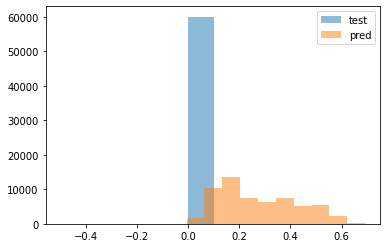

In [174]:
y_bottom = np.clip(-100, 0, y_bottom)
y_bottom = np.abs(y_bottom)

y_pred = model.predict(X_2d_bottom)
y_pred_inv = scaler.inverse_transform(y_pred)

plt.hist(y_bottom, alpha=0.5, label="test")
plt.hist(y_pred_inv,alpha=0.5, label="pred")
plt.legend()
plt.show()

# y_pred = model.predict(X_2d_bottom)
# plt.hist(y_bottom, alpha=0.5, label="test")
# plt.hist(y_pred,alpha=0.5, label="pred")
# plt.legend()
# plt.show()
